# Mava Quickstart Notebook



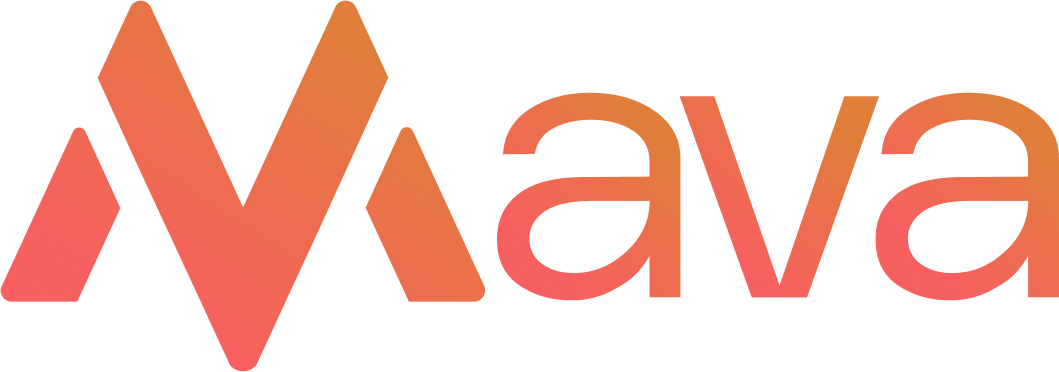

### This notebook offers a simple introduction to [Mava](https://github.com/instadeepai/Mava) by showing how to build and train a multi-agent PPO (MAPPO) system on the RobotWarehouse environment from [Jumanji](https://github.com/instadeepai/jumanji). Mava follows the design philosophy of [CleanRL](https://github.com/vwxyzjn/cleanrl) allowing for easy code readability and reuse, and is built on top of code from [PureJaxRL](https://github.com/luchris429/purejaxrl), extending it to provide end-to-end JAX-based multi-agent algorithms.

<a href="https://colab.research.google.com/github/instadeepai/Mava/blob/fix/quickstart-notebook/examples/Quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Requirements

We start by installing and importing the necessary packages.

In [1]:
# Cell not needed 
# %%capture
# @title Install required packages
# ! pip install git+https://github.com/instadeepai/mava.git@fix/quickstart-notebook

In [3]:
# @title Import required packages.

import time
from typing import Any, Sequence, Tuple

import chex
import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import tree

# Env requirements
import jumanji

# Plot requirements
import matplotlib.pyplot as plt
import numpy as np
import optax
import tensorflow_probability.substrates.jax.distributions as tfd
from colorama import Fore, Style
from flax.core.frozen_dict import FrozenDict
from flax.linen.initializers import orthogonal
from IPython.display import clear_output
from omegaconf import DictConfig, OmegaConf
from optax._src.base import OptState

# Mava Helpful functions and types
from mava.networks.distributions import IdentityTransformation
from mava.evaluator import get_eval_fn, make_ff_eval_act_fn
from mava.systems.ppo.types import LearnerState, OptStates, Params, PPOTransition
from mava.types import (
    ActorApply,
    CriticApply,
    ExperimentOutput,
    LearnerFn,
    Observation,
    ObservationGlobalState,
)
from mava.utils.jax_utils import (
    merge_leading_dims,
    unreplicate_batch_dim,
    unreplicate_n_dims,
)
from mava.utils.training import make_learning_rate
from mava.wrappers import (
    AgentIDWrapper,
    RwareWrapper,
)
from jumanji.environments.routing.robot_warehouse.generator import (
    RandomGenerator as RwareRandomGenerator,
)
from mava.utils import make_env as environments

%matplotlib inline
import seaborn as sns

sns.set()
sns.set_style("white")
sns.color_palette("colorblind")

import warnings

warnings.filterwarnings("ignore")

2024-10-30 21:02:01.581542: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Env

We try to make a new environment

In [81]:
from jumanji.env import Environment, specs
from chex import dataclass
from typing import NamedTuple
import abc
from jumanji.types import TimeStep, restart, termination, transition, truncation
from typing import Dict, Optional, Sequence, Tuple, Union

# Actions
NOOP = 0
UP = 1
DOWN = 2
LEFT = 3
RIGHT = 4
LOAD = 5

MOVES = jnp.array([[0, 0], [-1, 0], [1, 0], [0, -1], [0, 1], [0, 0]])

@dataclass
class SimpleOrchardEntity:
    """
    An entity that can be placed in the simple orchard environment (bot, apple, or tree).

    All fields are defined as a chex Array type with the shape as a comment beside it.
    A shape of () represents a scalar.

    id: unique number representing only this entity
    position: the position of this entity (x, y)
    """
    id: chex.Array # ()
    position: chex.Array #(2,)

@dataclass
class SimpleOrchardApple(SimpleOrchardEntity):
    """
    The desired collectable.
    """
    collected: chex.Array # () - bool: if the apple has been collected by a bot

@dataclass
class SimpleOrchardState:
    """
    Holds the state of the simple orchard using JAX fundementals
    """

    bots: SimpleOrchardEntity # List of bots (pytree structure)
    trees: SimpleOrchardEntity # List of trees (pytree structure)
    apples: SimpleOrchardApple # List of apples (pytree structure)
    time: chex.Array # ()
    key: chex.PRNGKey # (2,)

class SimpleOrchardObservation(NamedTuple):
    """
    The observation "seen" by the bots given to the neural network as the input layer.
    """
    # in the format (num_agents, [apple[i].position[0], apple[i].position[1], ..., bot[i].position[0], bot[i].position[1], ...])
    agents_view: chex.Array # (num_agents, 3 * (num_apples + num_trees + num_bots))
    action_mask: chex.Array # (num_agents, 6) since there are 6 actions in the simple env [UP, DOWN, LEFT, RIGHT, PICK, IDLE]
    time: chex.Array # ()

class SimpleOrchardGenerator:
    """
    Randomly generates simple orchard states in a reproduceable manner using JAX natives.
    """

    def __init__(
        self,
        width: int,
        height: int,
        num_bots: int = 2,
        num_trees: int = 5,
        num_apples: int = 10
    ) -> None:
        """
        Initalizes the parameters required for the simple orchard environment
        """

        self._width = width
        self._height = height
        self._num_bots = num_bots
        self._num_trees = num_trees
        self._num_apples = num_apples

    def get_width(self) -> int:
        return self._width

    def get_height(self) -> int:
        return self._height

    def get_num_bots(self) -> int:
        return self._num_bots

    def get_num_trees(self) -> int:
        return self._num_trees

    def get_num_apples(self) -> int:
        return self._num_apples

    def sample_trees(self, key: chex.PRNGKey) -> chex.Array:
        """
        Randomly place trees ensuring no trees are placed on the edge and no two trees are adjacent

        :param key: The key for the deterministic random number generator

        Returns: An array containing the flat indices of the trees on the grid.
        """

        flat_size = self._width * self._height
        pos_keys = jax.random.split(key, self._num_trees)

        # Create a mask to exclude edges
        mask = jnp.ones(flat_size, dtype=bool)
        mask = mask.at[jnp.arange(self._width)].set(False)  # top
        mask = mask.at[jnp.arange(flat_size - self._width, flat_size)].set(False)  # bottom
        mask = mask.at[jnp.arange(0, flat_size, self._width)].set(False)  # left
        mask = mask.at[jnp.arange(self._width - 1, flat_size, self._width)].set(False)  # right

        def take_positions(
            mask: chex.Array, key: chex.PRNGKey
        ) -> Tuple[chex.Array, chex.Array]:
            tree_flat_pos = jax.random.choice(key=key, a=flat_size, shape=(), p=mask)

            # Mask out adjacent positions to avoid placing food items next to each other
            adj_positions = jnp.array(
                [
                    tree_flat_pos,
                    tree_flat_pos + 1,  # right
                    tree_flat_pos - 1,  # left
                    tree_flat_pos + self._width,  # up
                    tree_flat_pos - self._width,  # down
                ]
            )

            return mask.at[adj_positions].set(False), tree_flat_pos

        _, tree_flat_positions = jax.lax.scan(take_positions, mask, pos_keys)

        # Unravel indices to get the 2D coordinates (x, y)
        tree_positions_x, tree_positions_y = jnp.unravel_index(
            tree_flat_positions, (self._width, self._height)
        )
        tree_positions = jnp.stack([tree_positions_x, tree_positions_y], axis=1)

        return tree_positions

    def sample_apples(self, key: chex.PRNGKey, mask: chex.Array) -> chex.Array:
        """Randomly samples apple positions on the grid, avoiding positions occupied by trees.

        Args:
            key (chex.PRNGKey): The random key.
            mask (chex.Array): The mask of the grid where 1s correspond to empty cells
            and 0s to full cells.

        Returns:
            chex.Array: An array containing the positions of apples on the grid.
                        Each row corresponds to the (x, y) coordinates of an apple.
        """
        apple_flat_positions = jax.random.choice(
            key=key,
            a=self._height * self._width,
            shape=(self._num_apples,),
            replace=False,  # Avoid agent positions overlaping
            p=mask,
        )
        # Unravel indices to get x and y coordinates
        apple_positions_x, apple_positions_y = jnp.unravel_index(
            apple_flat_positions, (self._width, self._height)
        )

        # Stack x and y coordinates to form a 2D array
        return jnp.stack([apple_positions_x, apple_positions_y], axis=1)

    def sample_agents(self, key: chex.PRNGKey, mask: chex.Array) -> chex.Array:
        """Randomly samples agent positions on the grid, avoiding positions occupied by trees.

        Args:
            key (chex.PRNGKey): The random key.
            mask (chex.Array): The mask of the grid where 1s correspond to empty cells
            and 0s to full cells.

        Returns:
            chex.Array: An array containing the positions of agents on the grid.
                        Each row corresponds to the (x, y) coordinates of an agent.
        """
        agent_flat_positions = jax.random.choice(
            key=key,
            a=self._height * self._width,
            shape=(self._num_bots,),
            replace=False,  # Avoid agent positions overlaping
            p=mask,
        )
        # Unravel indices to get x and y coordinates
        agent_positions_x, agent_positions_y = jnp.unravel_index(
            agent_flat_positions, (self._width, self._height)
        )

        # Stack x and y coordinates to form a 2D array
        return jnp.stack([agent_positions_x, agent_positions_y], axis=1)

    def sample_orchard(self, key: chex.PRNGKey) -> SimpleOrchardState:
        """
        Randomly creates an initial orchard state
        """

        (
            tree_pos_key,
            apple_pos_key,
            agent_pos_key,
            key,
        ) = jax.random.split(key, 4)

        # Generate Tree locations
        tree_positions = self.sample_trees(tree_pos_key)

        # Create a mask. The mask contains 0's where something already exists,
        # 1's where new things can be placed.
        mask = jnp.ones((self._width, self._height), dtype=bool)
        mask = mask.at[tree_positions].set(False)

        # Make the mask flat to pass into the choice function, then generate the apple locations
        apple_positions = self.sample_apples(key=apple_pos_key, mask=mask.ravel())

        mask = mask.at[apple_positions].set(False)
        
        agent_positions = self.sample_agents(key=agent_pos_key, mask=mask.ravel())

        # Create a pytree of generic entitys for the trees
        # The ID is just its position in the generated array
        trees = jax.vmap(SimpleOrchardEntity)(
            id=jnp.arange(self._num_trees),
            position=tree_positions
        )

        # Default the collected status to false
        apples = jax.vmap(SimpleOrchardApple)(
            id=jnp.arange(self._num_apples),
            position=apple_positions,
            collected=jnp.zeros((self._num_apples,), dtype=bool)
        )

        agents = jax.vmap(SimpleOrchardEntity)(
            id=jnp.arange(self._num_bots),
            position=agent_positions
        )

        time = jnp.array(0, jnp.int32)

        return SimpleOrchardState(
            key=key,
            time=time,
            bots=agents,
            trees=trees,
            apples=apples
        )

    def __call__(self, key: chex.PRNGKey) -> SimpleOrchardState:
        return self.sample_orchard(key)

class SimpleOrchardObserver:
    """
    This class vectorizes the SimpleOrchardEnvironment to pass into the neural network
    """

    def __init__(self, fov: int, width: int, height: int, num_bots: int, num_apples: int, num_trees: int) -> None:
        """
        Initalizes the observer object
        """

        self.fov = fov
        self.width = width
        self.height = height
        self.num_bots = num_bots
        self.num_apples = num_apples
        self.num_trees = num_trees
    
    def state_to_observation(self, state: SimpleOrchardState) -> SimpleOrchardObservation:
        """
        Convert the current state of the environment into observations for all agents.

        Args:
            state (State): The current state containing agent and food information.

        Returns:
            Observation: An Observation object containing the agents' views, action masks,
            and step count for all agents.
        """
        # Create the observation
        agents_view = jax.vmap(self.make_observation, (0, None))(state.bots, state)

        # Compute the action mask
        action_mask = jax.vmap(self.compute_action_mask, (0, None))(state.bots, state)

        return SimpleOrchardObservation(
            agents_view=agents_view,
            action_mask=action_mask,
            time=state.time,
        )

    def observation_spec(self, time_limit: int) -> specs.Spec[SimpleOrchardObservation]:
        """
        Returns the observation spec for the environment
        """
        max_observation = jnp.max(jnp.array([self.width, self.height]))
        agents_view = specs.BoundedArray(
            shape=(self.num_bots, 2 * (self.num_bots + self.num_trees + self.num_apples)),
            dtype=jnp.int32,
            name="agents_view",
            minimum=-1,
            maximum=max_observation,
        )

        return specs.Spec(
            SimpleOrchardObservation,
            "SimpleOrchardObservationSpec",
            agents_view=agents_view,
            action_mask=self._action_mask_spec(),
            time=self._time_spec(time_limit),
        )

    def _action_mask_spec(self) -> specs.BoundedArray:
        """
        Returns the action spec for the environment.

        The action mask is a boolean array of shape (num_agents, 6). '6' is the number of actions.
        """
        return specs.BoundedArray(
            shape=(self.num_bots, 6),
            dtype=bool,
            minimum=False,
            maximum=True,
            name="action_mask"
        )

    def _time_spec(self, time_limit: int) -> specs.BoundedArray:
        """Returns the step count spec for the environment."""
        return specs.BoundedArray(
            shape=(),
            dtype=jnp.int32,
            minimum=0,
            maximum=time_limit,
            name="time",
        )

    def transform_positions(
        self, agent: SimpleOrchardEntity, items: SimpleOrchardEntity
    ) -> chex.Array:
        """
        Calculate the positions of items within the agent's field of view.

        Args:
            agent (Agent): The agent whose position is used as the reference point.
            items: The items (other Agents, trees, and apples) to be transformed.

        Returns:
            chex.Array: The transformed positions of the items.
        """

        # TODO: Understand why this is necessary
        min_x = jnp.minimum(self.fov, agent.position[0])
        min_y = jnp.minimum(self.fov, agent.position[1])
        return items.position - agent.position + jnp.array([min_x, min_y])

    def extract_apples_info(
        self, agent: SimpleOrchardEntity, visible_apples: chex.Array, all_apples: SimpleOrchardApple
    ) -> Tuple[chex.Array, chex.Array]:
        """
        Extract the positions of visible apples.

        Args:
            agent (Agent): The agent observing the apples.
            visible_apples (chex.Array): A boolean array indicating the visibility of apples.
            all_apples (SimpleOrchardApple): Containing information about all the apples.

        Returns:
            Tuple[chex.Array, chex.Array]: A tuple of 1D arrays of the Xs and Ys of the apple positions
        """
        transformed_positions = self.transform_positions(agent, all_apples)

        apple_xs = jnp.where(visible_apples, transformed_positions[:, 0], -1)
        apple_ys = jnp.where(visible_apples, transformed_positions[:, 1], -1)

        return apple_xs, apple_ys

    def extract_trees_info(
        self, agent: SimpleOrchardEntity, visible_trees: chex.Array, all_trees: SimpleOrchardEntity
    ) -> Tuple[chex.Array, chex.Array]:
        """
        Extract the positions of visible apples.

        Args:
            agent (Agent): The agent observing the apples.
            visible_trees (chex.Array): A boolean array indicating the visibility of trees.
            all_trees (SimpleOrchardEntity): Containing information about all the trees.

        Returns:
            Tuple[chex.Array, chex.Array]: A tuple of 1D arrays of the Xs and Ys of the tree positions
        """
        transformed_positions = self.transform_positions(agent, all_trees)

        tree_xs = jnp.where(visible_trees, transformed_positions[:, 0], -1)
        tree_ys = jnp.where(visible_trees, transformed_positions[:, 1], -1)

        return tree_xs, tree_ys

    def extract_agents_info(
        self, agent: SimpleOrchardEntity, visible_agents: chex.Array, all_agents: SimpleOrchardEntity
    ) -> Tuple[chex.Array, chex.Array, chex.Array]:
        """
        Extract the positions and levels of visible agents excluding the current agent.

        Args:
            agent (Agent): The current agent.
            visible_agents (chex.Array): A boolean array indicating the visibility of other agents.
            all_agents (Agent): Containing information about all agents.

        Returns:
            Tuple[chex.Array, chex.Array, chex.Array]: A tuple of 1D arrays of the Xs and Ys of the agent positions
        """
        transformed_positions = self.transform_positions(agent, all_agents)
        agent_xs = jnp.where(visible_agents, transformed_positions[:, 0], -1)
        agent_ys = jnp.where(visible_agents, transformed_positions[:, 1], -1)

        # Remove the current agent's info from all agent's infos.
        agent_i_index = jnp.where(agent.id == all_agents.id, size=1)
        agent_i_infos = jnp.array(
            [
                agent_xs[agent_i_index],
                agent_ys[agent_i_index]
            ]
        ).ravel()

        other_agents_indices = jnp.where(
            agent.id != all_agents.id, size=self.num_bots - 1
        )
        agent_xs = agent_xs[other_agents_indices]
        agent_ys = agent_ys[other_agents_indices]

        return agent_i_infos, agent_xs, agent_ys

    def compute_action_mask(self, agent: SimpleOrchardEntity, state: SimpleOrchardState) -> chex.Array:
        """
        Calculate the action mask for a given agent based on the current state.

        Args:
            agent (Agent): The agent for which to calculate the action mask.
            state (State): The current state of the environment,
                        containing agent and food information.

        Returns:
            chex.Array: A boolean array representing the action mask for the given agent,
            where `True` indicates a valid action, and `False` indicates an invalid action.
        """
        # TODO: Actually implement a good action mask instead of letting the bot do whatever

        return jnp.ones((6,), dtype=bool)

    def make_observation(self, agent: SimpleOrchardEntity, state: SimpleOrchardState) -> chex.Array:
        """
        Make an observation for a single agent based on the current state of the environment.

        Args:
            agent (Agent): The agent for which to make the observation and action mask.
        Returns:
            agent_view (chex.Array): The observation for the given agent.
        """
        INFO_PER_ENTITY = 2 # There are two floats passed into the network, the X and Y coord of the entity

        # Calculate which agents are within the field of view (FOV) of the current agent
        # and are not the current agent itself.
        visible_agents = jnp.all(
            jnp.abs(agent.position - state.bots.position) <= self.fov,
            axis=-1,
        )

        visible_trees = jnp.all(
            jnp.abs(agent.position - state.trees.position) <= self.fov,
            axis=-1,
        )

        # Calculate which apples are within the FOV of the current agent and are not eaten.
        visible_apples = (
            jnp.all(
                jnp.abs(agent.position - state.apples.position) <= self.fov,
                axis=-1,
            )
            & ~state.apples.collected
        )

        # Placeholder observation for apppes, trees, and agents
        # this is shown if an entity is not in view.
        init_vals = jnp.array([-1 for _ in range(INFO_PER_ENTITY)])
        agent_view = jnp.tile(init_vals, self.num_apples + self.num_trees + self.num_bots)

        # Extract the positions of visible apples.
        apple_xs, apple_ys = self.extract_apples_info(
            agent, visible_apples, state.apples
        )

        # Extract the positions and levels of visible agents.
        agent_i_infos, agent_xs, agent_ys = self.extract_agents_info(
            agent, visible_agents, state.bots
        )

        tree_xs, tree_ys = self.extract_trees_info(
            agent, visible_trees, state.trees
        )

        end_apple_idx = INFO_PER_ENTITY * self.num_apples
        end_tree_idx = end_apple_idx + INFO_PER_ENTITY * self.num_trees

        # Assign the foods and agents infos.
        agent_view = agent_view.at[jnp.arange(0, end_apple_idx, INFO_PER_ENTITY)].set(apple_xs)
        agent_view = agent_view.at[jnp.arange(1, end_apple_idx, INFO_PER_ENTITY)].set(apple_ys)
        agent_view = agent_view.at[jnp.arange(end_apple_idx, end_tree_idx, INFO_PER_ENTITY)].set(tree_xs)
        agent_view = agent_view.at[jnp.arange(end_apple_idx + 1, end_tree_idx, INFO_PER_ENTITY)].set(tree_ys)

        # Always place the current agent's info first.
        agent_view = agent_view.at[
            jnp.arange(end_tree_idx, end_tree_idx + INFO_PER_ENTITY)
        ].set(agent_i_infos)

        start_idx = end_tree_idx + INFO_PER_ENTITY
        end_idx = start_idx + INFO_PER_ENTITY * (self.num_bots - 1)
        agent_view = agent_view.at[jnp.arange(start_idx, end_idx, INFO_PER_ENTITY)].set(agent_xs)
        agent_view = agent_view.at[jnp.arange(start_idx + 1, end_idx, INFO_PER_ENTITY)].set(agent_ys)

        return agent_view

class SimpleOrchard(Environment[SimpleOrchardState]):
    """
    An implementation of the Level-Based Foraging environment where agents need to
    cooperate to collect food and split the reward.

    Original implementation: https://github.com/semitable/lb-foraging/tree/master

    - `observation`: `Observation`
        - `agent_views`: Depending on the `observer` passed to `__init__`, it can be a
          `GridObserver` or a `VectorObserver`.
            - `GridObserver`: Returns an agent's view with a shape of
              (num_agents, 3, 2 * fov + 1, 2 * fov +1).
            - `VectorObserver`: Returns an agent's view with a shape of
              (num_agents, 3 * (num_food + num_agents).
        - `action_mask`: JAX array (bool) of shape (num_agents, 6)
          indicating for each agent which size actions
          (no-op, up, down, left, right, load) are allowed.
        - `step_count`: int32, the number of steps since the beginning of the episode.

    - `action`: JAX array (int32) of shape (num_agents,). The valid actions for each
        agent are (0: noop, 1: up, 2: down, 3: left, 4: right, 5: load).

    - `reward`: JAX array (float) of shape (num_agents,)
        When one or more agents load food, the food level is rewarded to the agents, weighted
        by the level of each agent. The reward is then normalized so that, at the end,
        the sum of the rewards (if all food items have been picked up) is one.

    - Episode Termination:
        - All food items have been eaten.
        - The number of steps is greater than the limit.

    - `state`: `State`
        - `agents`: Stacked Pytree of `Agent` objects of length `num_agents`.
            - `Agent`:
                - `id`: JAX array (int32) of shape ().
                - `position`: JAX array (int32) of shape (2,).
                - `level`: JAX array (int32) of shape ().
                - `loading`: JAX array (bool) of shape ().
        - `food_items`: Stacked Pytree of `Food` objects of length `num_food`.
            - `Food`:
                - `id`: JAX array (int32) of shape ().
                - `position`: JAX array (int32) of shape (2,).
                - `level`: JAX array (int32) of shape ().
                - `eaten`: JAX array (bool) of shape ().
        - `step_count`: JAX array (int32) of shape (), the number of steps since the beginning
          of the episode.
        - `key`: JAX array (uint) of shape (2,)
            JAX random generation key. Ignored since the environment is deterministic.

    Example:
    ```python
    from jumanji.environments import LevelBasedForaging
    env = LevelBasedForaging()
    key = jax.random.key(0)
    state, timestep = jax.jit(env.reset)(key)
    env.render(state)
    action = env.action_spec().generate_value()
    state, timestep = jax.jit(env.step)(state, action)
    env.render(state)
    ```

    Initialization Args:
    - `generator`: A `Generator` object that generates the initial state of the environment.
        Defaults to a `RandomGenerator` with the following parameters:
            - `grid_size`: 8
            - `fov`: 8 (full observation of the grid)
            - `num_agents`: 2
            - `num_food`: 2
            - `max_agent_level`: 2
            - `force_coop`: True
    - `time_limit`: The maximum number of steps in an episode. Defaults to 200.
    - `grid_observation`: If `True`, the observer generates a grid observation (default is `False`).
    - `normalize_reward`: If `True`, normalizes the reward (default is `True`).
    - `penalty`: The penalty value (default is 0.0).
    - `viewer`: Viewer to render the environment. Defaults to `LevelBasedForagingViewer`.
    """

    def __init__(
        self,
        generator: Optional[SimpleOrchardGenerator] = None,
        time_limit: int = 100,
        normalize_reward: bool = True,
        penalty: float = 0.0,
    ) -> None:
        super().__init__()

        self._generator = generator or SimpleOrchardGenerator(
            width=10,
            height=11
        )
        self.time_limit = time_limit
        self.width: int = self._generator.get_width()
        self.height: int = self._generator.get_height()
        self.num_bots: int = self._generator.get_num_bots()
        self.num_apples: int = self._generator.get_num_apples()
        self.num_trees: int = self._generator.get_num_trees()
        self.fov = 5
    
        self.normalize_reward = normalize_reward
        self.penalty = penalty
        self.num_obs_features = jnp.array(2 * (self.num_bots + self.num_apples + self.num_trees), jnp.int32)

        self._observer = SimpleOrchardObserver(
            fov=self.fov,
            width=self.width,
            height=self.height,
            num_bots=self.num_bots,
            num_apples=self.num_apples,
            num_trees=self.num_trees
        )

    def __repr__(self) -> str:
        return (
            "LevelBasedForaging(\n"
            + f"\t grid_width={self.width},\n"
            + f"\t grid_height={self.height},\n"
            + f"\t num_agents={self.num_bots}, \n"
            + f"\t num_food={self.num_apples}, \n"
            + f"\t num_trees={self.num_trees}\n"
            ")"
        )

    def reset(self, key: chex.PRNGKey) -> Tuple[SimpleOrchardState, TimeStep]:
        """Resets the environment.

        Args:
            key (chex.PRNGKey): Used to randomly generate the new `State`.

        Returns:
            Tuple[State, TimeStep]: `State` object corresponding to the new initial state
            of the environment and `TimeStep` object corresponding to the initial timestep.
        """
        state = self._generator(key)
        observation = self._observer.state_to_observation(state)
        timestep = restart(observation, shape=self.num_bots)
        timestep.extras = self._get_extra_info(state, timestep)

        return state, timestep

    def _simulate_agent_movement(
        self, agent: SimpleOrchardEntity, action: chex.Array, apples: SimpleOrchardApple, agents: SimpleOrchardEntity
    ) -> SimpleOrchardEntity:
        """
        Move the agent based on the specified action.
    
        Args:
            agent (SimpleOrchardEntity): The agent to move.
            action (chex.Array): The action to take.
            apples (SimpleOrchardApple): All apples in the grid.
            agents (SimpleOrchardEntity): All agents in the grid.
    
        Returns:
            Agent: The agent with its updated position.
        """
    
        # Calculate the new position based on the chosen action
        new_position = agent.position + MOVES[action]
    
        # Check if the new position is out of bounds
        out_of_bounds = jnp.any((new_position < 0) | (new_position[0] >= self.width) | (new_position[1] >= self.height))
    
        # Check if the new position is occupied by food or another agent
        agent_at_position = jnp.any(
            jnp.all(new_position == agents.position, axis=1) & (agent.id != agents.id)
        )
        apple_at_position = jnp.any(
            jnp.all(new_position == apples.position, axis=1) & ~apples.collected
        )
        entity_at_position = jnp.any(agent_at_position | apple_at_position)
    
        # Move the agent to the new position if it's a valid position,
        # otherwise keep the current position
        new_agent_position = jnp.where(
            out_of_bounds | entity_at_position, agent.position, new_position
        )
    
        # Return the agent with the updated position
        return SimpleOrchardEntity(
            id=agent.id,
            position=new_agent_position
        )
    
    def _flag_duplicates(self, a: chex.Array) -> chex.Array:
        """Return a boolean array indicating which elements of `a` are duplicates.
    
        Example:
            a = jnp.array([1, 2, 3, 2, 1, 5])
            flag_duplicates(a)  # jnp.array([True, False, True, False, True, True])
        """
        # https://stackoverflow.com/a/11528078/5768407
        _, indices, counts = jnp.unique(
            a, return_inverse=True, return_counts=True, size=len(a), axis=0
        )
        return ~(counts[indices] == 1)

    def _fix_collisions(self, moved_agents: SimpleOrchardEntity, original_agents: SimpleOrchardEntity) -> SimpleOrchardEntity:
        """
        Fix collisions in the moved agents by resolving conflicts with the original agents.
        If a number 'N' of agents end up in the same position after the move, the initial
        position of the agents is retained.
    
        Args:
            moved_agents (Agent): Agents with potentially updated positions.
            original_agents (Agent): Original agents with their initial positions.
    
        Returns:
            Agent: Agents with collisions resolved.
        """
        # Detect duplicate positions
        duplicates = self._flag_duplicates(moved_agents.position)
        duplicates = duplicates.reshape((duplicates.shape[0], -1))
    
        # If there are duplicates, use the original agent position.
        new_positions = jnp.where(
            duplicates,
            original_agents.position,
            moved_agents.position,
        )
    
        # Recreate agents with new positions
        agents: SimpleOrchardEntity = jax.vmap(SimpleOrchardEntity)(
            id=original_agents.id,
            position=new_positions
        )
        return agents

    def _update_agent_positions(
        self, agents: SimpleOrchardEntity, actions: chex.Array, apples: SimpleOrchardApple
    ) -> Any:
        """
        Update agent positions based on actions and resolve collisions.
    
        Args:
            agents (SimpleOrchardEntity): The current state of agents.
            actions (chex.Array): Actions taken by agents.
            apples (SimpleOrchardApple): All apples in the grid.
    
        Returns:
            Agent: Agents with updated positions.
        """
        # Move the agent to a valid position
        moved_agents = jax.vmap(self._simulate_agent_movement, (0, 0, None, None))(
            agents,
            actions,
            apples,
            agents
        )
    
        # Fix collisions
        moved_agents = self._fix_collisions(moved_agents, agents)
    
        return moved_agents

    def _are_entities_adjacent(self, entity_a: SimpleOrchardEntity, entity_b: SimpleOrchardEntity) -> chex.Array:
        """
        Check if two entities are adjacent in the grid.
    
        Args:
            entity_a (SimpleOrchardEntity): The first entity.
            entity_b (SimpleOrchardEntity): The second entity.
    
        Returns:
            chex.Array: True if entities are adjacent, False otherwise.
        """
        distance = jnp.abs(entity_a.position - entity_b.position)
        return jnp.where(jnp.sum(distance) == 1, True, False)

    def _eat_food(self, agents: SimpleOrchardEntity, apple: SimpleOrchardApple) -> Tuple[SimpleOrchardApple, chex.Array]:
        """Try to eat the provided food if possible.
    
        Args:
            agents(Agent): All agents in the grid.
            apple(SimpleOrchardApple): The food to attempt to eat.
    
        Returns:
            new_food (Food): Updated state of the food, indicating whether it was eaten.
            is_food_eaten_this_step (chex.Array): Whether or not the food was eaten at this step.
        """
    
        def is_eaten(agent: SimpleOrchardEntity, food: SimpleOrchardApple) -> chex.Array:
            """Return 1 if the agent is adjacent to the food, else 0."""
            return jax.lax.select(
                self._are_entities_adjacent(agent, food) & ~food.collected,
                1,
                0,
            )
    
        # Get the level of all adjacent agents that are trying to load the food
        adj_loading_agents_levels = jax.vmap(is_eaten, (0, None))(agents, apple)
    
        # If the food has already been eaten or is not loaded, the sum will be equal to 0
        is_food_eaten_this_step = jnp.sum(adj_loading_agents_levels) >= 0
    
        # Set food to eaten if it was eaten.
        new_food = apple.replace(collected=is_food_eaten_this_step | apple.collected)  # type: ignore
    
        return new_food, is_food_eaten_this_step

    def step(self, state: SimpleOrchardState, actions: chex.Array) -> Tuple[SimpleOrchardState, TimeStep]:
        """Simulate one step of the environment.

        Args:
            state (State): State  containing the dynamics of the environment.
            actions (chex.Array): Array containing the actions to take for each agent.

        Returns:
            Tuple[State, TimeStep]: `State` object corresponding to the next state and
            `TimeStep` object corresponding the timestep returned by the environment.
        """
        # Move agents, fix collisions that may happen and set loading status.
        moved_agents = self._update_agent_positions(state.bots, actions, state.apples)

        # Eat the food
        new_apples, eaten_this_step = jax.vmap(
            self._eat_food, (None, 0)
        )(moved_agents, state.apples)

        reward = self.get_reward(new_apples, eaten_this_step)

        state = SimpleOrchardState(
            bots=moved_agents,
            apples=new_apples,
            trees=state.trees,
            time=state.time + 1,
            key=state.key,
        )
        observation = self._observer.state_to_observation(state)

        # First condition is truncation, second is termination.
        terminate = jnp.all(state.apples.collected)
        truncate = state.time >= self.time_limit

        timestep = jax.lax.switch(
            terminate + 2 * truncate,
            [
                # !terminate !trunc
                lambda rew, obs: transition(
                    reward=rew, observation=obs, shape=self.num_bots
                ),
                # terminate !truncate
                lambda rew, obs: termination(
                    reward=rew, observation=obs, shape=self.num_bots
                ),
                # !terminate truncate
                lambda rew, obs: truncation(
                    reward=rew, observation=obs, shape=self.num_bots
                ),
                # terminate truncate
                lambda rew, obs: termination(
                    reward=rew, observation=obs, shape=self.num_bots
                ),
            ],
            reward,
            observation,
        )
        timestep.extras = self._get_extra_info(state, timestep)

        return state, timestep

    def _get_extra_info(self, state: SimpleOrchardState, timestep: TimeStep) -> Dict:
        """Computes extras metrics to be returned within the timestep."""
        n_eaten = state.apples.collected.sum() + timestep.extras.get(
            "eaten_food", jnp.float32(0)
        )
        percent_eaten = (n_eaten / self.num_apples) * 100
        return {"percent_eaten": percent_eaten}

    def get_reward(
        self,
        apples: SimpleOrchardApple,
        eaten_this_step: chex.Array,
    ) -> chex.Array:
        """Returns a reward for all agents given all food items.

        Args:
            apples (SimpleOrchardApple): All the apples in the environment.
            eaten_this_step (chex.Array): Whether the apple was eaten or not (this step). Boolean array of len num_apples
        """

        def get_reward_per_food(
            apple: SimpleOrchardApple,
            eaten_this_step: chex.Array,
        ) -> chex.Array:
            """Returns the reward for all agents given a single apple."""

            # Zero out all agents if food was not eaten and add penalty
            reward = eaten_this_step - self.penalty

            # jnp.nan_to_num: Used in the case where no agents are adjacent to the food
            normalizer = self.num_apples
            reward = jnp.where(
                self.normalize_reward, jnp.nan_to_num(reward / normalizer), reward
            )

            return reward

        # Get reward per food for all food items,
        # then sum it on the agent dimension to get reward per agent.
        reward_per_food = jax.vmap(get_reward_per_food, in_axes=(0, 0))(
            apples, eaten_this_step
        )
        return jnp.sum(reward_per_food, axis=0)

    def observation_spec(self) -> specs.Spec[Observation]:
        """Specifications of the observation of the environment.

        Returns:
            specs.Spec[Observation]: Spec for the `Observation` with fields grid,
            action_mask, and step_count.
        """
        return self._observer.observation_spec(
            self.time_limit,
        )

    def action_spec(self) -> specs.MultiDiscreteArray:
        """Returns the action spec for the Level Based Foraging environment.

        Returns:
            specs.MultiDiscreteArray: Action spec for the environment with shape (num_agents,).
        """
        return specs.MultiDiscreteArray(
            num_values=jnp.array([len(MOVES)] * self.num_bots),
            dtype=jnp.int32,
            name="action",
        )

    def reward_spec(self) -> specs.Array:
        """Returns the reward specification for the `LevelBasedForaging` environment.

        Since this is a multi-agent environment each agent gets its own reward.

        Returns:
            specs.Array: Reward specification, of shape (num_agents,) for the  environment.
        """
        return specs.Array(shape=(self.num_bots,), dtype=float, name="reward")

    def discount_spec(self) -> specs.BoundedArray:
        """Describes the discount returned by the environment.

        Returns:
            discount_spec: a `specs.BoundedArray` spec.
        """
        return specs.BoundedArray(
            shape=(self.num_bots,),
            dtype=float,
            minimum=0.0,
            maximum=1.0,
            name="discount",
        )

In [82]:
def test4():
    key = jax.random.key(0)
    gen = SimpleOrchardGenerator(10, 11, 2, 5, 10)
    observer = SimpleOrchardObserver(5, 10, 11, 2, 10, 5)

    env = SimpleOrchard(generator=gen)
    state, _ = env.reset(key)
    print(env.step(state, jnp.array([0, 0])))

def test3():
    key = jax.random.key(0)
    gen = SimpleOrchardGenerator(10, 11, 2, 5, 10)
    observer = SimpleOrchardObserver(5, 10, 11, 2, 10, 5)

    print(observer.state_to_observation(gen.sample_orchard(key)))

def test2():
    key = jax.random.key(0)
    
    gen = SimpleOrchardGenerator(10, 11)
    print(gen.sample_orchard(key))

def test():
    width = 11
    height = 1
    flat_size = width * height
    
    mask = jnp.ones(flat_size, dtype=bool)
    mask = mask.at[jnp.arange(width)].set(False)  # top
    mask = mask.at[jnp.arange(flat_size - width, flat_size)].set(False)  # bottom
    mask = mask.at[jnp.arange(0, flat_size, width)].set(False)  # left
    mask = mask.at[jnp.arange(width - 1, flat_size, width)].set(False)  # right

    print(mask.reshape((height, width)))

test4()

(SimpleOrchardState(bots=SimpleOrchardEntity(id=Array([0, 1], dtype=int32), position=Array([[0, 0],
       [0, 1]], dtype=int32)), trees=SimpleOrchardEntity(id=Array([0, 1, 2, 3, 4], dtype=int32), position=Array([[ 5,  6],
       [ 8,  6],
       [ 3, 10],
       [ 1,  4],
       [ 2,  9]], dtype=int32)), apples=SimpleOrchardApple(id=Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32), position=Array([[ 7,  7],
       [ 7,  9],
       [ 0,  2],
       [ 7,  4],
       [ 0,  7],
       [ 7,  0],
       [ 0,  1],
       [ 7,  2],
       [ 0,  5],
       [ 7, 10]], dtype=int32), collected=Array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True], dtype=bool)), time=Array(1, dtype=int32), key=Array((), dtype=key<fry>) overlaying:
[ 839183663 3740430601]), TimeStep(step_type=Array(2, dtype=int8), reward=Array(1.0000001, dtype=float32), discount=Array([0., 0.], dtype=float32), observation=SimpleOrchardObservation(agents_view=Array([[-1, -1, -1, -1, -1, -1, -1, -1, -1

# Trainer
This section encompasses the foundational methods required to set up the training process for MAPPO.


In [15]:
print(jax.devices())

[CudaDevice(id=0)]


### Network

Initially, we start by constructing the Actor and Critic networks using components from the Flax library.

* The `Actor()` network takes an observation as input and produces logits representing the probabilities of different actions. The shapes within the network are determined dynamically based on the number of agents, the observation, and the batch size.
* The `Critic()` network takes the global state as input and produces the estimated value of the state. Similar to the Actor network, the shapes within the network are handled implicitly by Flax.

In [3]:
class Actor(nn.Module):
    """Actor Network."""

    action_dim: Sequence[int]

    @nn.compact
    def __call__(self, observation: Observation) -> tfd.TransformedDistribution:
        """Forward pass."""
        x = observation.agents_view

        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(x)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(actor_output)
        actor_output = nn.relu(actor_output)
        actor_output = nn.Dense(self.action_dim, kernel_init=orthogonal(0.01))(actor_output)

        masked_logits = jnp.where(
            observation.action_mask,
            actor_output,
            jnp.finfo(jnp.float32).min,
        )

        return IdentityTransformation(distribution=tfd.Categorical(logits=masked_logits))


class Critic(nn.Module):
    """Critic Network."""

    @nn.compact
    def __call__(self, observation: ObservationGlobalState) -> chex.Array:
        """Forward pass."""
        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(observation.global_state)
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(128, kernel_init=orthogonal(np.sqrt(2)))(critic_output)
        critic_output = nn.relu(critic_output)
        critic_output = nn.Dense(1, kernel_init=orthogonal(1.0))(critic_output)

        return jnp.squeeze(critic_output, axis=-1)

### Learner Function
The `get_learner_fn` function returns a function which produces an `ExperimentOutput`, encapsulating the updated learner state, episode information, and loss metrics.

In [4]:
def get_learner_fn(
    env: jumanji.Environment,
    apply_fns: Tuple[ActorApply, CriticApply],
    update_fns: Tuple[optax.TransformUpdateFn, optax.TransformUpdateFn],
    config: DictConfig,
) -> LearnerFn[LearnerState]:
    """Get the learner function."""
    # Unpack apply and update functions.
    actor_apply_fn, critic_apply_fn = apply_fns
    actor_update_fn, critic_update_fn = update_fns

    def _update_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, Tuple]:
        """A single update of the network.

        This function steps the environment and records the trajectory batch for
        training. It then calculates advantages and targets based on the recorded
        trajectory and updates the actor and critic networks based on the calculated
        losses.

        Args:
        ----
            learner_state (NamedTuple):
                - params (Params): The current model parameters.
                - opt_states (OptStates): The current optimizer states.
                - key (PRNGKey): The random number generator state.
                - env_state (State): The environment state.
                - last_timestep (TimeStep): The last timestep in the current trajectory.
            _ (Any): The current metrics info.

        """

        def _env_step(learner_state: LearnerState, _: Any) -> Tuple[LearnerState, PPOTransition]:
            """Step the environment."""
            params, opt_states, key, env_state, last_timestep = learner_state

            # SELECT ACTION
            key, policy_key = jax.random.split(key)
            actor_policy = actor_apply_fn(params.actor_params, last_timestep.observation)
            value = critic_apply_fn(params.critic_params, last_timestep.observation)
            action = actor_policy.sample(seed=policy_key)
            log_prob = actor_policy.log_prob(action)

            # STEP ENVIRONMENT
            env_state, timestep = jax.vmap(env.step, in_axes=(0, 0))(env_state, action)

            # LOG EPISODE METRICS
            done = tree.map(
                lambda x: jnp.repeat(x, config.system.num_agents).reshape(config.arch.num_envs, -1),
                timestep.last(),
            )
            info = timestep.extras["episode_metrics"]

            transition = PPOTransition(
                done,
                action,
                value,
                timestep.reward,
                log_prob,
                last_timestep.observation,
                info,
            )
            learner_state = LearnerState(params, opt_states, key, env_state, timestep)
            return learner_state, transition

        # STEP ENVIRONMENT FOR ROLLOUT LENGTH
        learner_state, traj_batch = jax.lax.scan(
            _env_step, learner_state, None, config.system.rollout_length
        )

        # CALCULATE ADVANTAGE
        params, opt_states, key, env_state, last_timestep = learner_state
        last_val = critic_apply_fn(params.critic_params, last_timestep.observation)

        def _calculate_gae(
            traj_batch: PPOTransition, last_val: chex.Array
        ) -> Tuple[chex.Array, chex.Array]:
            """Calculate the GAE."""

            def _get_advantages(gae_and_next_value: Tuple, transition: PPOTransition) -> Tuple:
                """Calculate the GAE for a single transition."""
                gae, next_value = gae_and_next_value
                done, value, reward = (
                    transition.done,
                    transition.value,
                    transition.reward,
                )
                gamma = config.system.gamma
                delta = reward + gamma * next_value * (1 - done) - value
                gae = delta + gamma * config.system.gae_lambda * (1 - done) * gae
                return (gae, value), gae

            _, advantages = jax.lax.scan(
                _get_advantages,
                (jnp.zeros_like(last_val), last_val),
                traj_batch,
                reverse=True,
                unroll=16,
            )
            return advantages, advantages + traj_batch.value

        advantages, targets = _calculate_gae(traj_batch, last_val)

        def _update_epoch(update_state: Tuple, _: Any) -> Tuple:
            """Update the network for a single epoch."""

            def _update_minibatch(train_state: Tuple, batch_info: Tuple) -> Tuple:
                """Update the network for a single minibatch."""
                # UNPACK TRAIN STATE AND BATCH INFO
                params, opt_states, key = train_state
                traj_batch, advantages, targets = batch_info

                def _actor_loss_fn(
                    actor_params: FrozenDict,
                    actor_opt_state: OptState,
                    traj_batch: PPOTransition,
                    gae: chex.Array,
                    key: chex.PRNGKey,
                ) -> Tuple:
                    """Calculate the actor loss."""
                    # RERUN NETWORK
                    actor_policy = actor_apply_fn(actor_params, traj_batch.obs)
                    log_prob = actor_policy.log_prob(traj_batch.action)

                    # CALCULATE ACTOR LOSS
                    ratio = jnp.exp(log_prob - traj_batch.log_prob)
                    gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                    loss_actor1 = ratio * gae
                    loss_actor2 = (
                        jnp.clip(
                            ratio,
                            1.0 - config.system.clip_eps,
                            1.0 + config.system.clip_eps,
                        )
                        * gae
                    )
                    loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                    loss_actor = loss_actor.mean()
                    # The seed will be used in the TanhTransformedDistribution:
                    entropy = actor_policy.entropy(seed=key).mean()

                    total_loss_actor = loss_actor - config.system.ent_coef * entropy
                    return total_loss_actor, (loss_actor, entropy)

                def _critic_loss_fn(
                    critic_params: FrozenDict,
                    critic_opt_state: OptState,
                    traj_batch: PPOTransition,
                    targets: chex.Array,
                ) -> Tuple:
                    """Calculate the critic loss."""
                    # RERUN NETWORK
                    value = critic_apply_fn(critic_params, traj_batch.obs)

                    # CALCULATE VALUE LOSS
                    value_pred_clipped = traj_batch.value + (value - traj_batch.value).clip(
                        -config.system.clip_eps, config.system.clip_eps
                    )
                    value_losses = jnp.square(value - targets)
                    value_losses_clipped = jnp.square(value_pred_clipped - targets)
                    value_loss = 0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()

                    critic_total_loss = config.system.vf_coef * value_loss
                    return critic_total_loss, (value_loss)

                # CALCULATE ACTOR LOSS
                key, entropy_key = jax.random.split(key)
                actor_grad_fn = jax.value_and_grad(_actor_loss_fn, has_aux=True)
                actor_loss_info, actor_grads = actor_grad_fn(
                    params.actor_params,
                    opt_states.actor_opt_state,
                    traj_batch,
                    advantages,
                    entropy_key,
                )

                # CALCULATE CRITIC LOSS
                critic_grad_fn = jax.value_and_grad(_critic_loss_fn, has_aux=True)
                critic_loss_info, critic_grads = critic_grad_fn(
                    params.critic_params,
                    opt_states.critic_opt_state,
                    traj_batch,
                    targets,
                )

                # Compute the parallel mean (pmean) over the batch.
                # This calculation is inspired by the Anakin architecture demo notebook.
                # available at https://tinyurl.com/26tdzs5x
                # This pmean could be a regular mean as the batch axis is on the same device.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="batch"
                )
                # pmean over devices.
                actor_grads, actor_loss_info = jax.lax.pmean(
                    (actor_grads, actor_loss_info), axis_name="device"
                )

                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="batch"
                )
                # pmean over devices.
                critic_grads, critic_loss_info = jax.lax.pmean(
                    (critic_grads, critic_loss_info), axis_name="device"
                )

                # UPDATE ACTOR PARAMS AND OPTIMISER STATE
                actor_updates, actor_new_opt_state = actor_update_fn(
                    actor_grads, opt_states.actor_opt_state
                )
                actor_new_params = optax.apply_updates(params.actor_params, actor_updates)

                # UPDATE CRITIC PARAMS AND OPTIMISER STATE
                critic_updates, critic_new_opt_state = critic_update_fn(
                    critic_grads, opt_states.critic_opt_state
                )
                critic_new_params = optax.apply_updates(params.critic_params, critic_updates)

                new_params = Params(actor_new_params, critic_new_params)
                new_opt_state = OptStates(actor_new_opt_state, critic_new_opt_state)

                # PACK LOSS INFO
                total_loss = actor_loss_info[0] + critic_loss_info[0]
                value_loss = critic_loss_info[1]
                actor_loss = actor_loss_info[1][0]
                entropy = actor_loss_info[1][1]
                loss_info = {
                    "total_loss": total_loss,
                    "value_loss": value_loss,
                    "actor_loss": actor_loss,
                    "entropy": entropy,
                }
                return (new_params, new_opt_state, entropy_key), loss_info

            params, opt_states, traj_batch, advantages, targets, key = update_state
            key, shuffle_key, entropy_key = jax.random.split(key, 3)

            # SHUFFLE MINIBATCHES
            batch_size = config.system.rollout_length * config.arch.num_envs
            permutation = jax.random.permutation(shuffle_key, batch_size)
            batch = (traj_batch, advantages, targets)
            batch = tree.map(lambda x: merge_leading_dims(x, 2), batch)
            shuffled_batch = tree.map(lambda x: jnp.take(x, permutation, axis=0), batch)
            minibatches = tree.map(
                lambda x: jnp.reshape(x, [config.system.num_minibatches, -1] + list(x.shape[1:])),
                shuffled_batch,
            )

            # UPDATE MINIBATCHES
            (params, opt_states, entropy_key), loss_info = jax.lax.scan(
                _update_minibatch, (params, opt_states, entropy_key), minibatches
            )

            update_state = (params, opt_states, traj_batch, advantages, targets, key)
            return update_state, loss_info

        update_state = (params, opt_states, traj_batch, advantages, targets, key)

        # UPDATE EPOCHS
        update_state, loss_info = jax.lax.scan(
            _update_epoch, update_state, None, config.system.ppo_epochs
        )

        params, opt_states, traj_batch, advantages, targets, key = update_state
        learner_state = LearnerState(params, opt_states, key, env_state, last_timestep)
        metric = traj_batch.info
        return learner_state, (metric, loss_info)

    def learner_fn(learner_state: LearnerState) -> ExperimentOutput[LearnerState]:
        """Learner function.

        This function represents the learner, it updates the network parameters
        by iteratively applying the `_update_step` function for a fixed number of
        updates. The `_update_step` function is vectorized over a batch of inputs.

        Args:
        ----
            learner_state (NamedTuple):
                - params (Params): The initial model parameters.
                - opt_states (OptStates): The initial optimizer states.
                - key (chex.PRNGKey): The random number generator state.
                - env_state (LogEnvState): The environment state.
                - timesteps (TimeStep): The initial timestep in the initial trajectory.

        """
        batched_update_step = jax.vmap(_update_step, in_axes=(0, None), axis_name="batch")

        learner_state, (episode_info, loss_info) = jax.lax.scan(
            batched_update_step, learner_state, None, config.system.num_updates_per_eval
        )
        return ExperimentOutput(
            learner_state=learner_state,
            episode_metrics=episode_info,
            train_metrics=loss_info,
        )

    return learner_fn

### Learner Setup
The learner setup initialises components for training: the learner function, actor and critic networks and optimizers and environment states. It creates a function for learning, employs parallel processing over the cores for efficiency, and sets up initial states.

In [5]:
def learner_setup(
    env: jumanji.Environment, keys: chex.Array, config: DictConfig
) -> Tuple[LearnerFn[LearnerState], Actor, LearnerState]:
    """Initialise learner_fn, network, optimiser, environment and states."""
    # Get available TPU cores.
    n_devices = len(jax.devices())

    # Get number of agents.
    config.system.num_agents = env.num_agents

    # PRNG keys.
    key, actor_net_key, critic_net_key = keys

    # Define network and optimiser.
    actor_network = Actor(env.action_dim)
    critic_network = Critic()

    actor_lr = make_learning_rate(config.system.actor_lr, config)
    critic_lr = make_learning_rate(config.system.critic_lr, config)

    actor_optim = optax.chain(
        optax.clip_by_global_norm(config.system.max_grad_norm),
        optax.adam(actor_lr, eps=1e-5),
    )
    critic_optim = optax.chain(
        optax.clip_by_global_norm(config.system.max_grad_norm),
        optax.adam(critic_lr, eps=1e-5),
    )

    # Initialise observation with obs of all agents.
    obs = env.observation_spec().generate_value()
    init_x = tree.map(lambda x: x[jnp.newaxis, ...], obs)

    # Initialise actor params and optimiser state.
    actor_params = actor_network.init(actor_net_key, init_x)
    actor_opt_state = actor_optim.init(actor_params)

    # Initialise critic params and optimiser state.
    critic_params = critic_network.init(critic_net_key, init_x)
    critic_opt_state = critic_optim.init(critic_params)

    # Pack params.
    params = Params(actor_params, critic_params)

    # Pack apply and update functions.
    apply_fns = (actor_network.apply, critic_network.apply)
    update_fns = (actor_optim.update, critic_optim.update)

    # Get batched iterated update and replicate it to pmap it over cores.
    learn = get_learner_fn(env, apply_fns, update_fns, config)
    learn = jax.pmap(learn, axis_name="device")

    # Initialise environment states and timesteps: across devices and batches.
    key, *env_keys = jax.random.split(
        key, n_devices * config.system.update_batch_size * config.arch.num_envs + 1
    )
    env_states, timesteps = jax.vmap(env.reset, in_axes=(0))(
        jnp.stack(env_keys),
    )
    reshape_states = lambda x: x.reshape(
        (n_devices, config.system.update_batch_size, config.arch.num_envs) + x.shape[1:]
    )
    # (devices, update batch size, num_envs, ...)
    env_states = jax.tree.map(reshape_states, env_states)
    timesteps = jax.tree.map(reshape_states, timesteps)

    # Define params to be replicated across devices and batches.
    key, step_keys = jax.random.split(key)
    opt_states = OptStates(actor_opt_state, critic_opt_state)
    replicate_learner = (params, opt_states, step_keys)

    # Duplicate learner for update_batch_size.
    broadcast = lambda x: jnp.broadcast_to(x, (config.system.update_batch_size,) + x.shape)
    replicate_learner = jax.tree.map(broadcast, replicate_learner)

    # Duplicate learner across devices.
    replicate_learner = flax.jax_utils.replicate(replicate_learner, devices=jax.devices())

    # Initialise learner state.
    params, opt_states, step_keys = replicate_learner
    init_learner_state = LearnerState(params, opt_states, step_keys, env_states, timesteps)

    return learn, actor_network, init_learner_state

# Rendering and logging tools

### Rendering
The `render_one_episode` function simulates and visualises one episode from rolling out a trained MAPPO model that will be passed to the function using `actors_params`.

In [6]:
def render_one_episode(config, params, max_steps=100) -> None:
    """Rollout episodes of a trained MAPPO policy."""
    # Create envs
    env_config = {**config.env.kwargs, **config.env.scenario.env_kwargs}
    generator = RwareRandomGenerator(**config.env.scenario.task_config)
    env = jumanji.make(config.env.scenario.name, generator=generator, **env_config)
    env = RwareWrapper(env)
    if config.system.add_agent_id:
        env = AgentIDWrapper(env)

    # Create actor networks (We only care about the policy during rendering)
    actor_network = Actor(env.action_dim)
    apply_fn = actor_network.apply

    reset_fn = jax.jit(env.reset)
    step_fn = jax.jit(env.step)
    key = jax.random.PRNGKey(config.system.seed)
    key, reset_key = jax.random.split(key)
    state, timestep = reset_fn(reset_key)

    states = [state]
    episode_return = 0
    episode_length = 0
    while not timestep.last():
        key, action_key = jax.random.split(key)
        pi = apply_fn(params, timestep.observation)

        if config["arch"]["evaluation_greedy"]:
            action = pi.mode()
        else:
            action = pi.sample(seed=action_key)
        state, timestep = step_fn(state, action)
        states.append(state)
        episode_return += jnp.mean(timestep.reward)
        episode_length += 1

    # Print out the results of the episode
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE RETURN: {episode_return}{Style.RESET_ALL}")
    print(f"{Fore.CYAN}{Style.BRIGHT}EPISODE LENGTH:{episode_length}{Style.RESET_ALL}")

    # Limit the number of steps to record to the maximum number of steps
    steps = min([max_steps, len(states) - 1])
    states = states[:steps]

    # Render the episode
    env.animate(states=states, interval=100, save_path="./rware.gif")

### Logging:
The `plot_performance` function visualises the performance of the algorithm. This plot will be refreshed each time evaluation interval happens!

In [7]:
def plot_performance(mean_episode_return, ep_returns, start_time):
    plt.figure(figsize=(8, 4))
    clear_output(wait=True)

    # Plot the data
    ep_returns.append(mean_episode_return)
    plt.plot(
        np.linspace(0, (time.time() - start_time) / 60.0, len(list(ep_returns))), list(ep_returns)
    )
    plt.xlabel("Run Time [Minutes]")
    plt.ylabel("Episode Return")
    plt.title("Robotic Warehouse with 4 Agents")

    # Show the plot
    plt.show()
    return ep_returns

# Experiment Setup

The experiment setup includes: defining the hyperparameters, creating environments, setting up the learner and evaluator, and initialising some variables for plotting and logging purposes.


#### Config

We start the experiment setup by defining the config dictionary that represents a set of the various hyperparameters for the experiment.

In addition to the typical hyperparameters used in MARL algorithms, we define below a few variables relevant to our implementation:

`num_updates`: The number of gradient updates to perform during the training.

`num_envs`:  Number of vectorised environments per device. For instance, if set to 512, it implies that 512 environments will be running in parallel at the same time on a given process.

`num_evaluation` and `num_eval_episodes`: The `num_evaluation` parameter specifies how many evenly spaced evaluation steps will occur during training, while the `num_eval_episode` specifies how many episodes will be rolled out at each evaluation step.

In [8]:
config = {
    "system": {
        "actor_lr": 2.5e-4,
        "critic_lr": 2.5e-4,
        "update_batch_size": 2,
        "rollout_length": 128,
        "num_updates": 400,
        "ppo_epochs": 16,
        "num_minibatches": 32,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "clip_eps": 0.2,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "add_agent_id": True,
        "decay_learning_rates": False,
        "seed": 42,
    },
    "arch": {
        "num_envs": 512,
        "num_eval_episodes": 32,
        "num_evaluation": 50,
        "evaluation_greedy": False,
        "num_absolute_metric_eval_episodes": 32,
    },
    "env": {
        "env_name": "RobotWarehouse",
        "eval_metric": "episode_return",
        "implicit_agent_id": False,
        "log_win_rate": False,
        "kwargs": {"time_limit": 500},
        "scenario": {
            "name": "RobotWarehouse-v0",
            "task_name": "tiny-4ag-easy",
            "task_config": {
                "column_height": 8,
                "shelf_rows": 1,
                "shelf_columns": 3,
                "num_agents": 4,
                "sensor_range": 1,
                "request_queue_size": 8,
            },
            "env_kwargs": {},
        },
    },
}
# Convert the Python dictionary to a DictConfig
config: DictConfig = OmegaConf.create(config)

#### Create the Training and Evaluation environments

We use Mava's utility functions to create our environments for us. These environments will have a seuqnece of wrappers applied to them that will add agent identifiers and will log any relevant metrics. Since MAPPO has a centralised critic, we will also need the environment to return the true underlying environment state along with the individual agent observations. This is why we pass in `add_global_state=True`. FOr more information on all the wrappers that are applied, please see [here](https://github.com/instadeepai/Mava/blob/8b758133056e86303ab1acbe5aa2ade02e0f6e70/mava/utils/make_env.py#L86).

In [9]:
env, eval_env = environments.make(config, add_global_state=True)

#### Additional variable definitions


In this section of the code, the total number of timesteps for the experiment is calculated, followed by the partitioning of the training timesteps into distinct intervals determined by the value of `num_evaluation`.

**Calculating Total Timesteps:**

To calculate the total timesteps, the following formula is used:
```
total_timesteps = n_devices
* num_updates
* rollout_length
* update_batch_size
* num_envs
```
- `n_devices` represents the number of JAX devices available, which is essential for parallel computation.
- `num_updates` is the number of vectorised gradient updates to be be performed on each device.
- `rollout_length` is the number of timesteps in each rollout.
- `update_batch_size` is the batch size used for each update.
- `num_envs` is the number of parallel environments used for data collection.

This computation yields the total count of timesteps that will be carried out throughout the complete training procedure. Consequently, the number of timesteps within each training interval is established as ```total_timesteps/num_evaluation```





In [10]:
def compute_total_timesteps(config: DictConfig):
    # Calculate total timesteps.
    n_devices = len(jax.devices())
    config["system"]["num_updates_per_eval"] = (
        config["system"]["num_updates"] // config["arch"]["num_evaluation"]
    )
    steps_per_rollout = (
        n_devices
        * config["system"]["num_updates_per_eval"]
        * config["system"]["rollout_length"]
        * config["system"]["update_batch_size"]
        * config["arch"]["num_envs"]
    )

    return steps_per_rollout, config

#### The Learner and Evaluator Setup



In [11]:
# PRNG keys.
key, key_e, actor_net_key, critic_net_key = jax.random.split(
    jax.random.PRNGKey(config.system.seed), num=4
)

# Setup learner.
learn, actor_network, learner_state = learner_setup(
    env, (key, actor_net_key, critic_net_key), config
)

eval_act_fn = make_ff_eval_act_fn(actor_network.apply, config)

# Setup evaluator.
evaluator = get_eval_fn(eval_env, eval_act_fn, config, absolute_metric=False)
absolute_metric_evaluator = get_eval_fn(eval_env, eval_act_fn, config, absolute_metric=True)

# Add total timesteps to the config and compute environment steps per rollout.
steps_per_rollout, config = compute_total_timesteps(config)

# Run Experiment

#### Execute the experiment

Now that the code has been compiled using JAX, its execution will benefit from optimised performance. We will proceed to train the MAPPO algorithm on the `small-4ag-easy` scenario from RobotWarehouse. The experiment follows a cyclic pattern, transitioning from training to evaluation and back to training.

The training phase consists of performing 400 updates. Each update utilizes 512 parallel environments, with a rollout of 128 steps per environment and a batch of two vectorised full gradient update steps are performend. This comprehensive process results in over 50 million timesteps utilised for training.

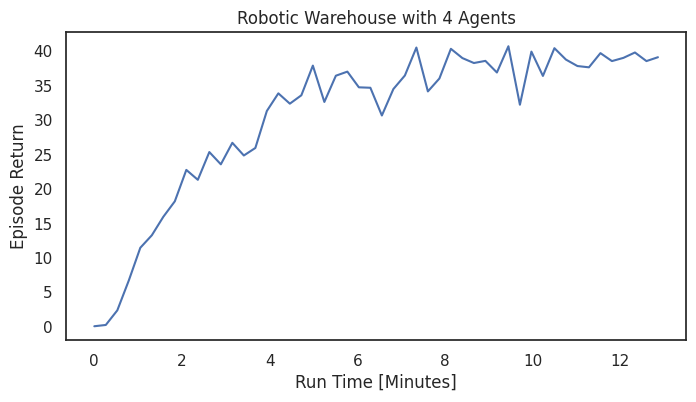

MAPPO experiment completed


In [12]:
# Run experiment for a total number of evaluations.
ep_returns = []
start_time = time.time()
n_devices = len(jax.devices())

for _ in range(config["arch"]["num_evaluation"]):
    # Train.
    learner_output = learn(learner_state)
    jax.block_until_ready(learner_output)

    # Prepare for evaluation.
    trained_params = unreplicate_batch_dim(learner_state.params.actor_params)

    key_e, *eval_keys = jax.random.split(key_e, n_devices + 1)
    eval_keys = jnp.stack(eval_keys)
    eval_keys = eval_keys.reshape(n_devices, -1)

    # Evaluate.
    evaluator_output = evaluator(trained_params, eval_keys, {})
    jax.block_until_ready(evaluator_output)

    mean_episode_return = jnp.mean(evaluator_output["episode_return"])
    ep_returns = plot_performance(mean_episode_return, ep_returns, start_time)

    # Update runner state to continue training.
    learner_state = learner_output.learner_state

# Return trained params to be used for rendering or testing.
trained_params = unreplicate_n_dims(trained_params, unreplicate_depth=1)

print(f"{Fore.CYAN}{Style.BRIGHT}MAPPO experiment completed{Style.RESET_ALL}")

#### Rendering

Now let's render one episode using the trained system

> Note: Creating a complete episode animation can be time-consuming. To address this, we offer a parameter named `max_steps` for the `render_one_episode` function. This parameter determines the number of states displayed in the GIF. Please note that a full episode usually consists of 500 steps.

In [13]:
render_one_episode(config, trained_params)

EPISODE RETURN: 50.0
EPISODE LENGTH:500


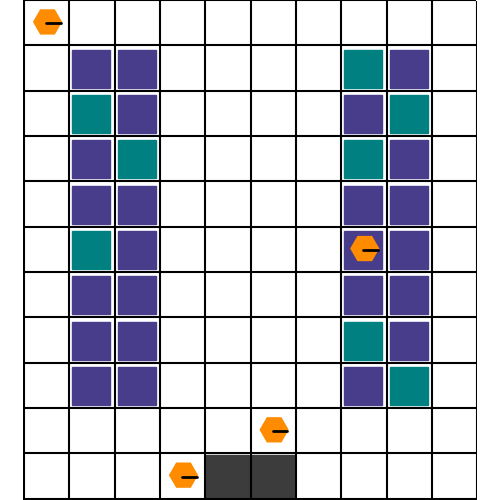

In [14]:
import os

from IPython.display import Image

if os.path.exists("/content/rware.gif"):
    display(Image(filename="/content/rware.gif"))
else:
    display(Image(filename="./rware.gif"))